In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from sklearn.metrics import roc_curve

## Load data and perfom exploratory analysis

In [3]:
#load data and 
df = pd.read_csv('dataR2.csv')
df.head(10)

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
5,49,22.854458,92,3.226,0.732087,6.8317,13.679750,10.31760,530.410,1
6,89,22.700000,77,4.690,0.890787,6.9640,5.589865,12.93610,1256.083,1
7,76,23.800000,118,6.470,1.883201,4.3110,13.251320,5.10420,280.694,1
8,73,22.000000,97,3.350,0.801543,4.4700,10.358725,6.28445,136.855,1
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,1


In [4]:
df.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474282,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


Text(0, 0.5, 'Label')

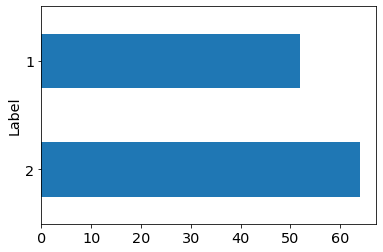

In [116]:
df['Classification'].value_counts().plot(kind='barh', fontsize='x-large').set_ylabel('Label', fontsize='x-large')

## Train (80%) and test (20%) split

In [8]:
#randomly split into train and evaluate sets
#set random seed for results to be reproducible 
np.random.seed(88)
mask = np.random.rand(len(df), 1) <= 0.8
#df['split'] = np.random.randn(len(df), 1)
x_train = df[mask]
x_eval = df[~mask]
#df['Classification'].unique(), covert 1,2 to 0,1
y_train = x_train.pop('Classification') - 1
y_eval = x_eval.pop('Classification') - 1

## Preprocessing: build feature_columns and input functions for prediction model

In [9]:
#processing for categorical and numerical columns
#no categorical columns in this dataset
# cat_columns = [] 
# def one_hot_cat_column(feature_name, vocab):
#     return tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))
cat_colums =[]
numer_columns = ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']
feature_columns = []

# for feature_name in cat_columns:
#     vocabulary = x_train[feature_name].unique()
#     feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
for feature_name in cat_colums:
    vocabulary = x_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numer_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [10]:
#make input function
n_examples = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(n_examples)
        
        dataset = dataset.repeat(n_epochs)
        
        dataset = dataset.batch(n_examples)
        return dataset
    return input_fn

In [41]:
train_input_fn = make_input_fn(x_train, y_train)
eval_input_fn = make_input_fn(x_eval, y_eval, shuffle=False, n_epochs=1)

In [39]:
ds = make_input_fn(x_train, y_train)()
for feature_batch, label_batch in ds.take(1):
    print('Feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['Glucose'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())
#evaluate age column values
#age_column = feature_columns[0]
#tf.keras.layers.DenseFeatures(age_column)(feature_batch).numpy()

Feature keys: ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']

A batch of class: [ 92  85 152  83 118 102 103  83  87 103 112  89  92 134 101  90  84 139
  92  96  95 114  90 104  92 138  97  88 103 116  77  94 105  98  92  79
  99  91  92  76  60 196  90  85  70  93  88 108  83 106  93  94  97  98
  77  98  86 201  92 101 199 102  74  94 101  85  87  95  90 101  89  92
 134  82  78 102  70 128  93  75  84  97 103  83  86  92 119  82  97 131
  84]

A batch of Labels: [0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0]


## Results for Logistic, 0.6 predication accuracy was obtained.

In [112]:
#logistic regression
linear_est = tf.estimator.LinearClassifier(feature_columns)
linear_est.train(train_input_fn, max_steps=200)
#eval of logistic regression
result = linear_est.evaluate(eval_input_fn)
clear_output()
print('Logistic regression:')
print()
print(pd.Series(result))


Logistic regression:

accuracy                  0.600000
accuracy_baseline         0.520000
auc                       0.682692
auc_precision_recall      0.697509
average_loss              2.031751
label/mean                0.520000
loss                      2.031751
precision                 0.571429
prediction/mean           0.832425
recall                    0.923077
global_step             200.000000
dtype: float64


## Results for Boosted Tree, 0.8 predication accuracy was obtained.

In [111]:
#boosted tree

params = {
  'n_trees': 100,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True,
  'learning_rate': 0.01,
}
bt_est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
bt_est.train(train_input_fn, max_steps=200)
# Evaluation.
bt_result = bt_est.evaluate(eval_input_fn)

clear_output()
print('Boosted tree:')
print()
print(pd.Series(bt_result))
# print('Logistic regression: {}'.format(result))
# print('Boosted tree: {}'.format(bt_result))

Boosted tree:

accuracy                  0.800000
accuracy_baseline         0.520000
auc                       0.807692
auc_precision_recall      0.863028
average_loss              0.541260
label/mean                0.520000
loss                      0.541260
precision                 0.833333
prediction/mean           0.499871
recall                    0.769231
global_step             200.000000
dtype: float64


## ROC curve for comparison of prediction models: Boosted Tree is better than Logistic.

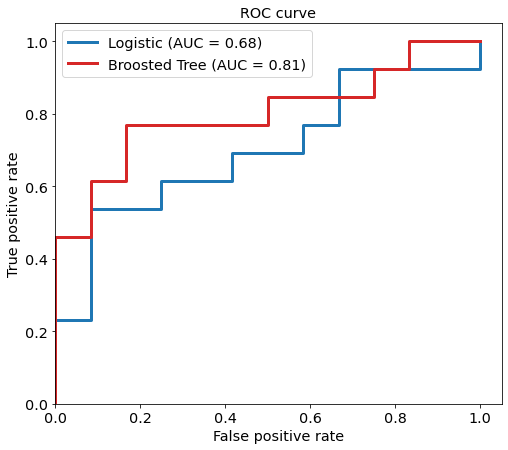

In [107]:
#ROC curve for both models

pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

pred_dicts_bt = list(bt_est.predict(eval_input_fn))
probs_bt = pd.Series([pred['probabilities'][1] for pred in pred_dicts_bt])
clear_output()
fpr, tpr, _ = roc_curve(y_eval, probs)
fig, ax = plt.subplots(figsize=(8,7))
plt.plot(fpr, tpr, linewidth=3)
plt.title('ROC curve', fontsize='x-large')
plt.xlabel('False positive rate', fontsize='x-large')
plt.ylabel('True positive rate', fontsize='x-large')
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

fpr, tpr, _ = roc_curve(y_eval, probs_bt)
plt.plot(fpr, tpr, color='#d62728', linewidth=3)
plt.legend(['Logistic (AUC = {0:0.2f})'''.format(result['auc']), 
            'Broosted Tree (AUC = {0:0.2f})'''.format(bt_result['auc'])],
          fontsize='x-large')

## Feature importance visualization: Directional feature contributions plot and Gain based feature importance 

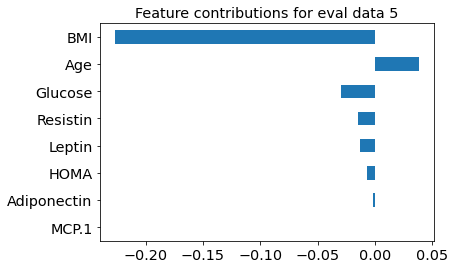

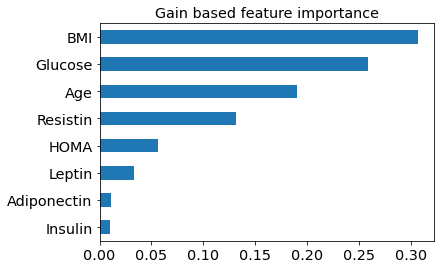

In [108]:
#make directional feature contributions plot

pred_dicts = list(bt_est.experimental_predict_with_explanations(eval_input_fn))
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
clear_output()
#plt.figure(1)
ID = 5
example = df_dfc.iloc[ID] #choose ith example from eval set
TOP_N = 8 # top 8 features
sorted_ix = example.abs().sort_values()[-TOP_N: ].index
ax = example[sorted_ix].plot(kind='barh')
plt.title('Feature contributions for eval data 5', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()

#gain_based feature importance
importance = bt_est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importance)
#visualize importance
plt.figure(2)
N = 8
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh'))

plt.title('Gain based feature importance', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()
